# Deep Neural Collaborative Filtering

Use concatenate and dot product to build the deep recommender model

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split_cap

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,USER,ITEM,RATING,TIMESTAMP
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [9]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split_cap(DATA, [0.8, 0.2])

In [10]:
train.shape, test.shape

((80000, 5), (20000, 5))

## Deep Neural CF

This is a model with both dot and concatenate layers

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [12]:
def Neural_CF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    
    # Item Embedding MF
    item_embedding_mf = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                  embeddings_initializer='he_normal',
                                  name='ItemEmbeddingMF')(item_input)
    item_vec_mf = Flatten(name='FlattenItemMF')(item_embedding_mf)
    
    
    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                embeddings_initializer='he_normal',
                               name='ItemEmbeddingMLP')(item_input)
    item_vec_mlp = Flatten(name='FlattenItemMLP')(item_embedding_mlp)
    

    # User Layer
    user_input = Input(shape=[1], name='User')
    
    # User Embedding MF
    user_embedding_mf = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), 
                                embeddings_initializer='he_normal',
                               name='UserEmbeddingMF')(user_input)
    user_vec_mf = Flatten(name='FlattenUserMF')(user_embedding_mf)
    
    # User Embedding MF
    user_embedding_mlp = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='he_normal',
                               name='UserEmbeddingMLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUserMLP')(user_embedding_mlp)
    
    # Multiply MF paths
    DotProductMF = Dot(axes=1, name='DotProductMF')([item_vec_mf, user_vec_mf])
    
    # Concat MLP paths
    ConcatMLP = Concatenate(name='ConcatMLP')([item_vec_mlp, user_vec_mlp])
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(50, name="Dense1")(ConcatMLP)
    Dense_2 = Dense(20, name="Dense2")(Dense_1)

    # Concatenate MF and MLP paths
    Concat = Concatenate(name="ConcatAll")([DotProductMF, Dense_2])
    
    # Use Dense to learn non-linear dense representation
    Pred = Dense(1, name="Pred")(Concat)
    

    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Pred with bias added
    PredAddBias = Add(name="AddBias")([Pred, item_bias_vec, user_bias_vec])
    
    
    # Scaling for each user
    y = Activation('sigmoid')(PredAddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [13]:
n_factors = 40
model = Neural_CF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbeddingMLP (Embedding)  │ (None, 1, 40)             │          67,280 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbeddingMLP (Embedding)  │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemMLP (Flatten)      │ (None, 40)                │               0 │ ItemEmbeddingMLP[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserMLP (Flatten)      │ (None, 40)                │               0 │ UserEmbeddingMLP[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbeddingMF (Embedding)   │ (None, 1, 40)             │          67,280 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbeddingMF (Embedding)   │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ConcatMLP (Concatenate)       │ (None, 80)                │               0 │ FlattenItemMLP[0][0],      │
│                               │                           │                 │ FlattenUserMLP[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemMF (Flatten)       │ (None, 40)                │               0 │ ItemEmbeddingMF[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserMF (Flatten)       │ (None, 40)                │               0 │ UserEmbeddingMF[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense1 (Dense)                │ (None, 50)                │           4,050 │ ConcatMLP[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProductMF (Dot)            │ (None, 1)                 │               0 │ FlattenItemMF[0][0],       │
│                               │                           │                 │ FlattenUserMF[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense2 (Dense)                │ (None, 20)                │           1,020 │ Dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ConcatAll (Concatenate)       │ (None, 21)                │               0 │ DotProductMF[0][0],        │
│                               │                           │                 │ Dense2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemBias (Embedding)          │ (None, 1, 1)              │           1,68

 Total params: 217,717 (850.46 KB)

 Trainable params: 217,717 (850.46 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


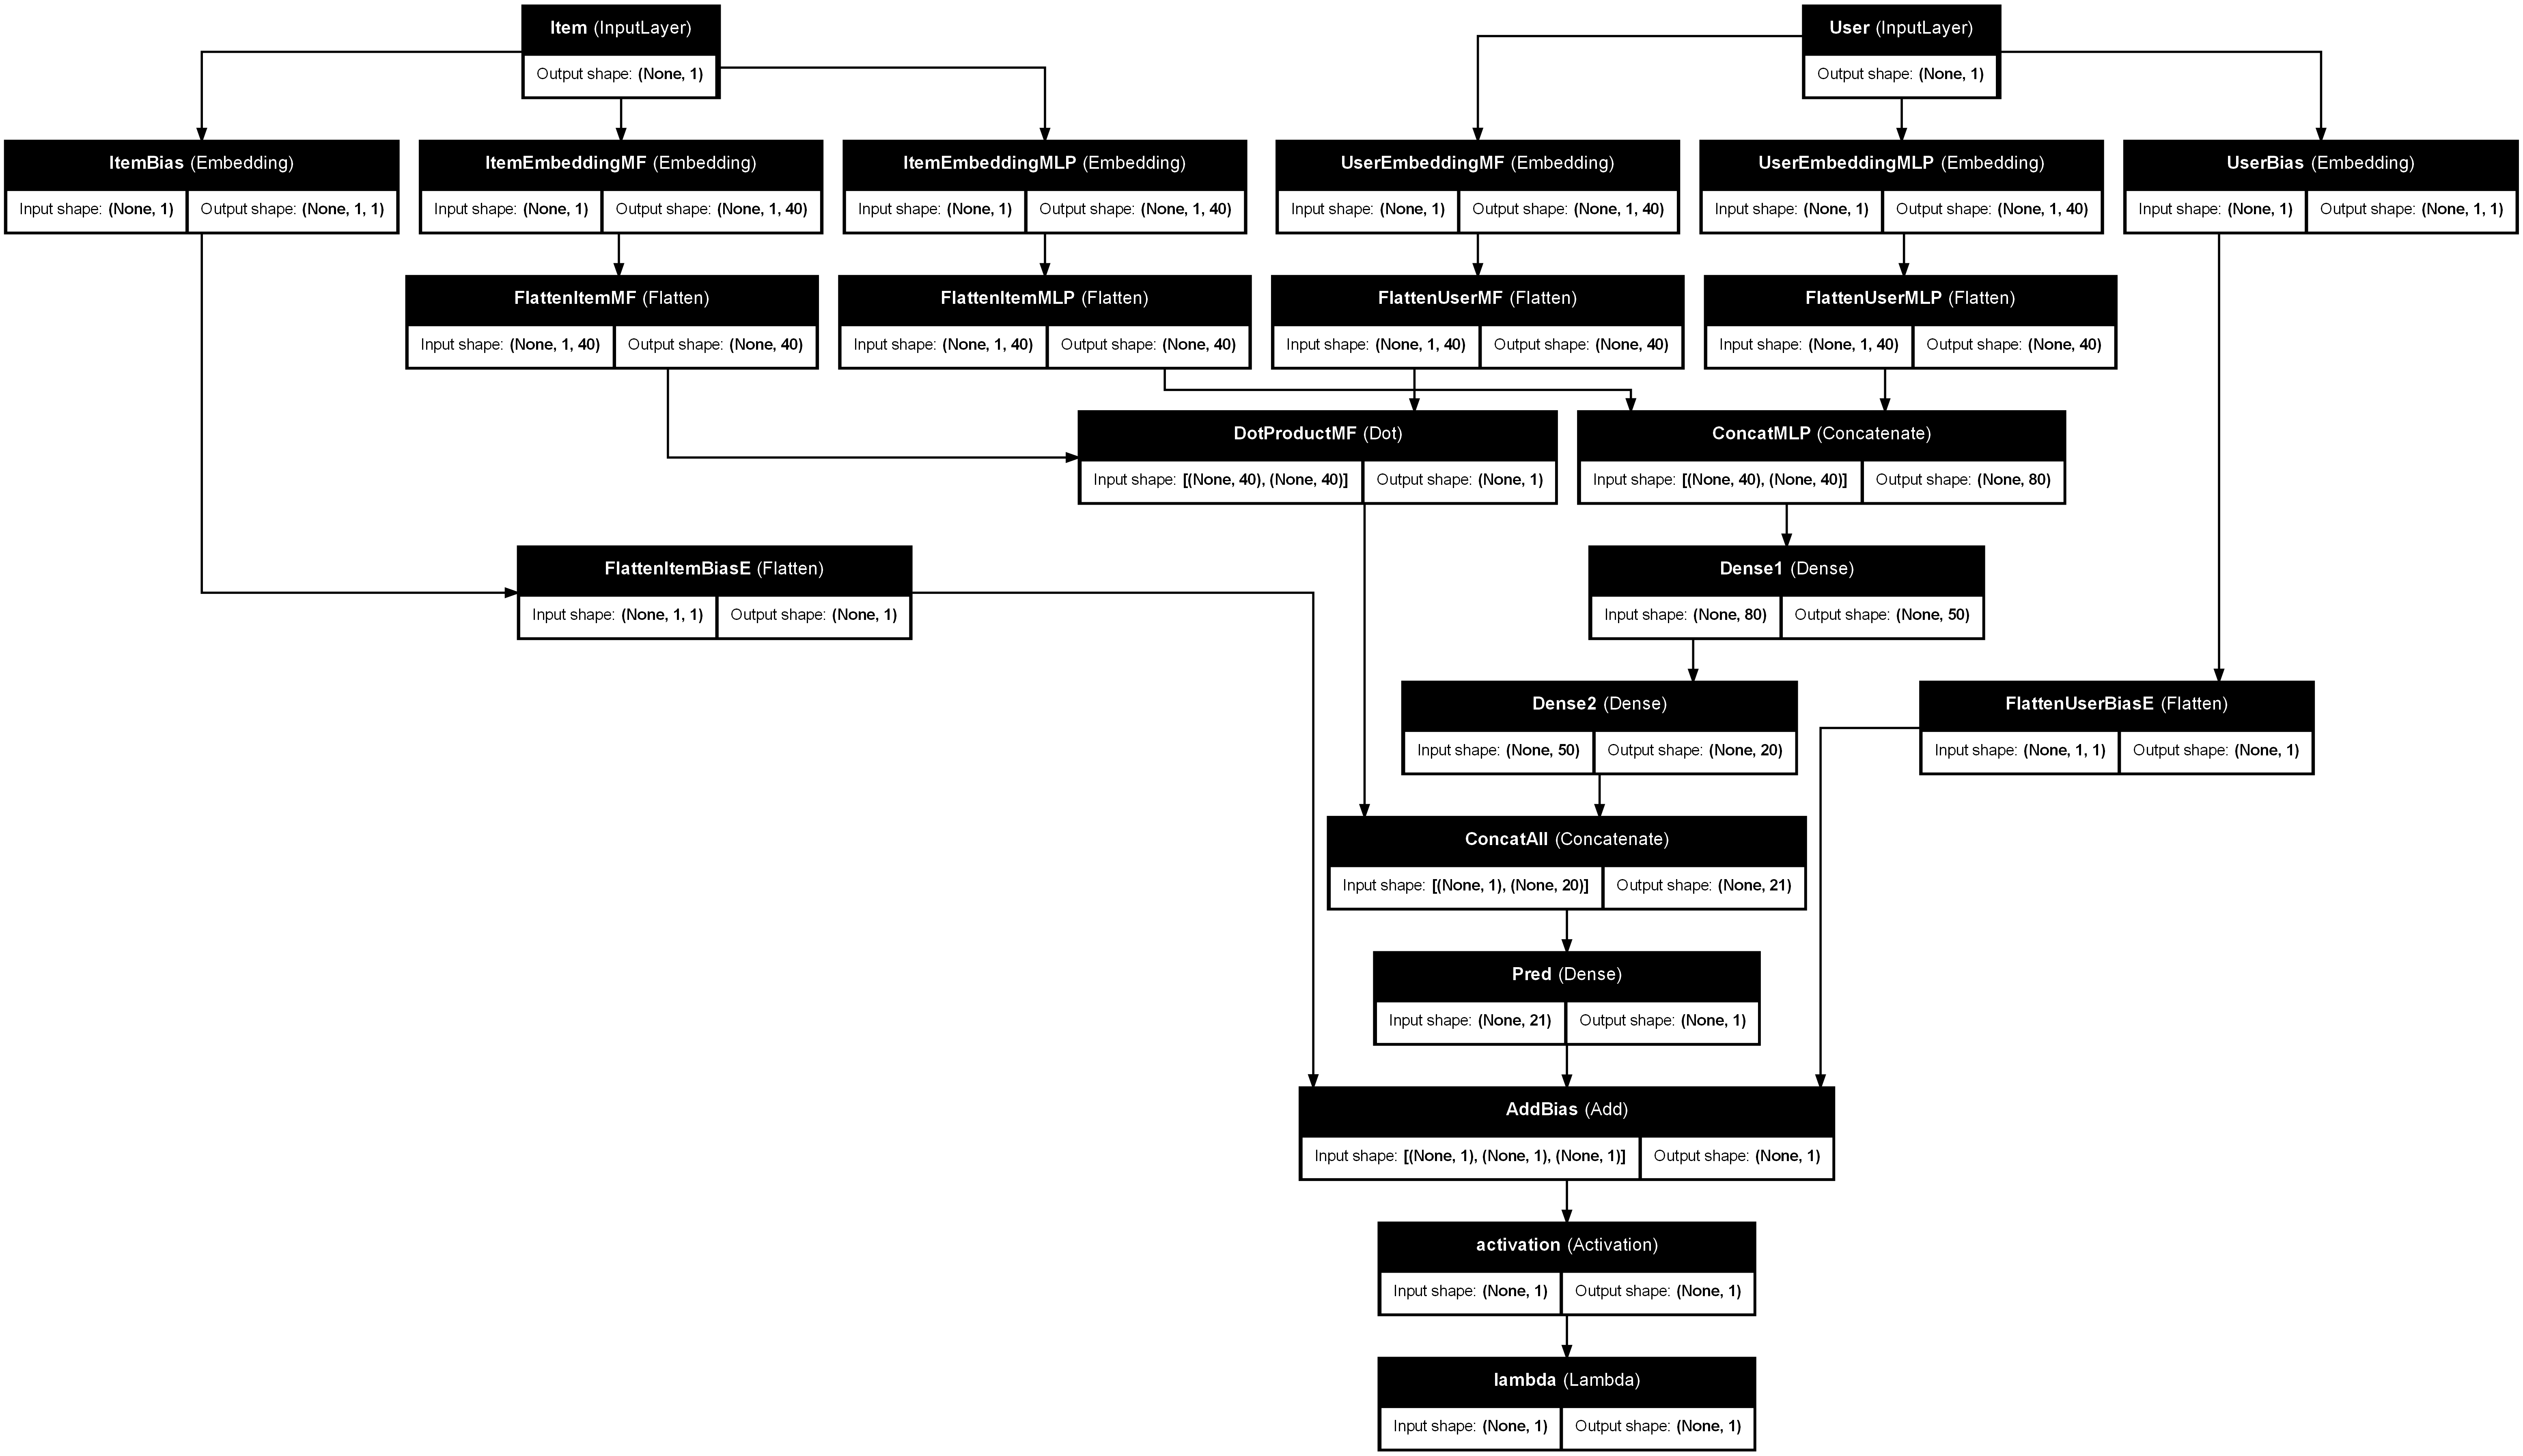

In [16]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Neural-CF.png" )

### Train the Model

In [17]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0871 - val_loss: 1.0139
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8734 - val_loss: 1.0095
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7476 - val_loss: 1.0048
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5106 - val_loss: 1.0063
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3620 - val_loss: 1.0090
Wall time: 15.7 s


In [18]:
#vis.metrics(output.history)

### Score the Model

In [19]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9858


0.9855151176452637

### Evaluate the Model

In [20]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [21]:
item_embedding_mf = get_embedding(model, "ItemEmbeddingMF")
user_embedding_mf = get_embedding(model, "UserEmbeddingMF")
item_embedding_mlp = get_embedding(model, "ItemEmbeddingMLP")
user_embedding_mlp = get_embedding(model, "UserEmbeddingMLP")

In [22]:
item_embedding = np.mean([item_embedding_mf,item_embedding_mlp], axis=0)
user_embedding = np.mean([user_embedding_mf,user_embedding_mlp], axis=0)

In [23]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step
Wall time: 2min 28s


In [24]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,3.504385
1,195,301,4.212209
2,195,376,2.445132
3,195,50,3.573292
4,195,345,3.815261


In [25]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step
Wall time: 2min 5s


In [26]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.066299
Precision@K:	0.046978
Recall@K:	0.022097


### Get Similar Items

In [27]:
from reco.recommend import get_similar, show_similar

In [28]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 164 ms


In [29]:
item_similar_indices

array([[   0,  890, 1234, 1518,  821],
       [   1,  816, 1645, 1484, 1298],
       [   2, 1166, 1397, 1327,  665],
       ...,
       [1679, 1593, 1413, 1639, 1545],
       [1680, 1555, 1624, 1413, 1545],
       [1681, 1545, 1678, 1413, 1639]], dtype=int64)

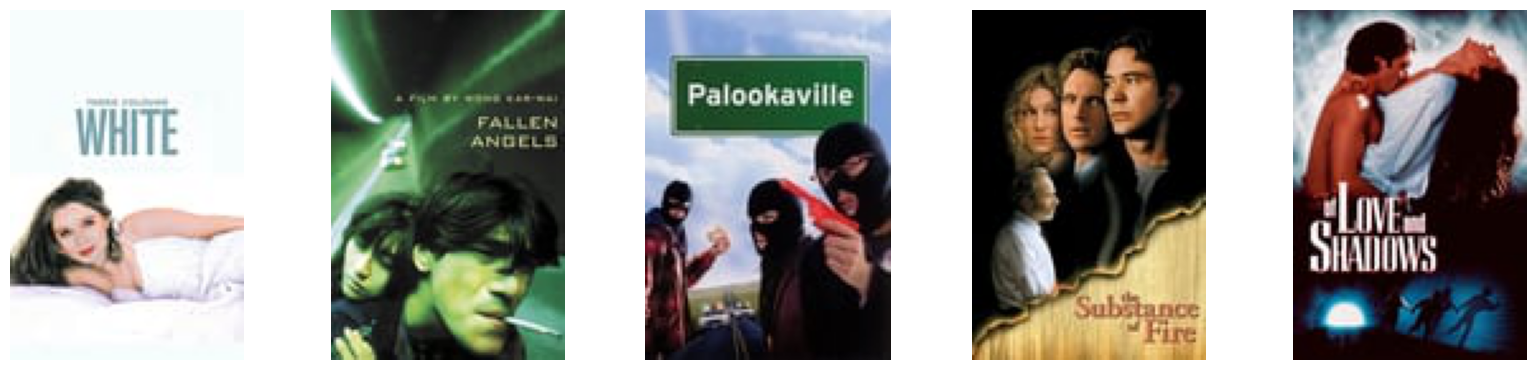

In [31]:
show_similar(60, item_similar_indices, item_encoder)